# Diversity Score on the MovieLens Dataset

In this notebook, we look at measuring diversity of movie consumption in the MovieLens dataset. This dataset comes from the interaction between users and movies at [MovieLens](https://movielens.org/), a public movie recommendation service run by [GroupLens](https://grouplens.org/), based at the University of Minesotta.

Our goal is to try Spotify's diversity measure on the MovieLens dataset. This will require training a MovieLens model on the dataset, followed by computing the Generalist-Specialist metric on users.

In [1]:
import os
import pandas as pd
import numpy as np
import re
import logging  
import multiprocessing
import matplotlib
import matplotlib.pyplot as plt
import requests
import seaborn as sns

from time import time
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser
from tqdm import tqdm

from core.util import *
from core.metrics import *

%matplotlib inline

font = {"size" : 18}
matplotlib.rc('font', **font)

logger = setup_logging()

## Dataset Download and Preparation

First we download the dataset into the current working directory and unzip it. We also set up the paths to the user interaction with movies and ratings they gave.

In [3]:
dataset_dir_name = "ml-latest"
base_path = os.path.join(os.getcwd(), dataset_dir_name)
ratings_path = os.path.join(base_path, "ratings.csv")

In [3]:
if not os.path.exists(base_path):
    dataset_url = "http://files.grouplens.org/datasets/movielens/" + dataset_dir_name + ".zip"
    # don't download if not necessary     
    if not os.path.exists(base_path + ".zip"):
        download_dataset(dataset_url, base_path + ".zip")
    
    logger.info("unzipping file")
    unzip_file(dataset_dir_name + ".zip")

## Read and Explore Dataset

Note that unlike in Spotify, since the total number of users here are a lot smaller than at Spotify, we opt to train the model on the entire dataset. We have to convert the `movidId` column to `str` from `int` because the model accepts only a sequence of strings.

In [4]:
ratings_df = pd.read_csv(ratings_path)

In [5]:
ratings_df["date"] = pd.to_datetime(ratings_df["timestamp"], unit="s")
ratings_df["month"] = ratings_df["date"].dt.month
ratings_df["year"] = ratings_df["date"].dt.year
ratings_df["movieId"] = ratings_df["movieId"].apply(str)

In [13]:
users_movies = ratings_df.sort_values(by=["timestamp"]).groupby(
    "userId", 
    as_index=False
).apply(
    lambda x: dict(zip(x["movieId"], x["rating"]))
).reset_index(name="movie_id_ratings")

In [14]:
sequence_distribution = users_movies["movie_id_ratings"].apply(lambda x: len(x))

Here we can see some statistics about the dataset. The ratings start from 1995 and lasted till 2018. Moreover, the number of movies watched and rated follows a power-law distribution.

In [8]:
min_year = ratings_df["year"].min()
max_year = ratings_df["year"].max()
max_sequence_length = sequence_distribution.max()
min_sequence_length = sequence_distribution.min()
median_sequence_length = sequence_distribution.median()
avg_sequence_length = sequence_distribution.mean()
logger.info(f"Earliest year: {min_year}")
logger.info(f"Latest year: {max_year}")
logger.info(f"Number of users: {sequence_distribution.shape[0]}")
logger.info(f"Minimum number of movies watched and rated: {min_sequence_length}")
logger.info(f"Median number of movies watched and rated: {median_sequence_length}")
logger.info(f"Average number of movies watched and rated: {round(avg_sequence_length, 2)}")
logger.info(f"Maximum number of movies watched and rated: {max_sequence_length}")

INFO - 00:07:54: Earliest year: 1995
INFO - 00:07:54: Latest year: 2018
INFO - 00:07:54: Number of users: 283228
INFO - 00:07:54: Minimum number of movies watched and rated: 1
INFO - 00:07:54: Median number of movies watched and rated: 30.0
INFO - 00:07:54: Average number of movies watched and rated: 97.99
INFO - 00:07:54: Maximum number of movies watched and rated: 23715


## Training the Model

Here, we train the Word2Vec model. We set our model parameters to 
* item vector size at 50 dimensions, 
* window size of 5, and
* the minimum item count is 5, which means a movie needs to appear at least 5 times before it is included in the model.
All other parameters follow the default parameter values specified in the GenSim docs.

We use the **continuous bag-of-words** training method here. Most sequences are not very long, so a window size of length 5 is reasonable. **Note**: we have not performed any hyperparameter optimization in this notebook, our goal is to demonstrate the diversity scoring.

In [9]:
# model parameters
ITEM_VECTOR_SIZE = 60  # dimension of word vector size (multiple of 4 for best performance)
MIN_ITEM_COUNT = 5 # minimum number of times a word must appear in the dataset to be included as a word vector
WINDOW_SIZE = 5

In [10]:
movies_list = users_movies["movie_id_ratings"].apply(lambda x: list(x.keys()))

In [11]:
cores = multiprocessing.cpu_count()
model = Word2Vec(min_count=MIN_ITEM_COUNT,
                     window=WINDOW_SIZE,
                     size=ITEM_VECTOR_SIZE,
                     workers=cores-1)

In [12]:
t = time()
model.build_vocab(movies_list, progress_per=10000)
logger.info("Time to build vocab: {} mins".format(round((time() - t) / 60, 2)))

INFO - 16:21:33: collecting all words and their counts
INFO - 16:21:33: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 16:21:33: PROGRESS: at sentence #10000, processed 994882 words, keeping 22011 word types
INFO - 16:21:33: PROGRESS: at sentence #20000, processed 1955233 words, keeping 25926 word types
INFO - 16:21:33: PROGRESS: at sentence #30000, processed 2901806 words, keeping 28887 word types
INFO - 16:21:33: PROGRESS: at sentence #40000, processed 3879652 words, keeping 31329 word types
INFO - 16:21:33: PROGRESS: at sentence #50000, processed 4873537 words, keeping 33318 word types
INFO - 16:21:33: PROGRESS: at sentence #60000, processed 5833186 words, keeping 34816 word types
INFO - 16:21:34: PROGRESS: at sentence #70000, processed 6816332 words, keeping 36633 word types
INFO - 16:21:34: PROGRESS: at sentence #80000, processed 7772985 words, keeping 38394 word types
INFO - 16:21:34: PROGRESS: at sentence #90000, processed 8731983 words, keeping 39544 w

In [13]:
t = time()
model.train(movies_list, total_examples=model.corpus_count, epochs=15, report_delay=1)
logger.info("Time to train the model: {} mins".format(round((time() - t) / 60, 2)))

INFO - 16:21:42: training model with 11 workers on 30824 vocabulary and 60 features, using sg=0 hs=0 sample=0.001 negative=5 window=5
INFO - 16:21:43: EPOCH 1 - PROGRESS: at 10.47% examples, 2850170 words/s, in_qsize 21, out_qsize 0
INFO - 16:21:44: EPOCH 1 - PROGRESS: at 21.05% examples, 2861682 words/s, in_qsize 19, out_qsize 2
INFO - 16:21:45: EPOCH 1 - PROGRESS: at 31.73% examples, 2871038 words/s, in_qsize 21, out_qsize 0
INFO - 16:21:46: EPOCH 1 - PROGRESS: at 41.91% examples, 2859931 words/s, in_qsize 22, out_qsize 2
INFO - 16:21:47: EPOCH 1 - PROGRESS: at 52.53% examples, 2864713 words/s, in_qsize 19, out_qsize 2
INFO - 16:21:48: EPOCH 1 - PROGRESS: at 62.86% examples, 2867881 words/s, in_qsize 21, out_qsize 0
INFO - 16:21:49: EPOCH 1 - PROGRESS: at 73.28% examples, 2872269 words/s, in_qsize 21, out_qsize 0
INFO - 16:21:50: EPOCH 1 - PROGRESS: at 83.95% examples, 2875442 words/s, in_qsize 21, out_qsize 0
INFO - 16:21:51: EPOCH 1 - PROGRESS: at 94.33% examples, 2876773 words/s, 

INFO - 16:22:30: EPOCH 5 - PROGRESS: at 94.37% examples, 2877767 words/s, in_qsize 21, out_qsize 0
INFO - 16:22:30: worker thread finished; awaiting finish of 10 more threads
INFO - 16:22:30: worker thread finished; awaiting finish of 9 more threads
INFO - 16:22:30: worker thread finished; awaiting finish of 8 more threads
INFO - 16:22:30: worker thread finished; awaiting finish of 7 more threads
INFO - 16:22:30: worker thread finished; awaiting finish of 6 more threads
INFO - 16:22:30: worker thread finished; awaiting finish of 5 more threads
INFO - 16:22:30: worker thread finished; awaiting finish of 4 more threads
INFO - 16:22:30: worker thread finished; awaiting finish of 3 more threads
INFO - 16:22:30: worker thread finished; awaiting finish of 2 more threads
INFO - 16:22:30: worker thread finished; awaiting finish of 1 more threads
INFO - 16:22:30: worker thread finished; awaiting finish of 0 more threads
INFO - 16:22:30: EPOCH - 5 : training on 27753444 raw words (27622237 effec

INFO - 16:23:09: worker thread finished; awaiting finish of 0 more threads
INFO - 16:23:09: EPOCH - 9 : training on 27753444 raw words (27622355 effective words) took 9.6s, 2871067 effective words/s
INFO - 16:23:10: EPOCH 10 - PROGRESS: at 10.47% examples, 2832298 words/s, in_qsize 21, out_qsize 0
INFO - 16:23:11: EPOCH 10 - PROGRESS: at 21.08% examples, 2875467 words/s, in_qsize 21, out_qsize 0
INFO - 16:23:12: EPOCH 10 - PROGRESS: at 31.60% examples, 2857094 words/s, in_qsize 21, out_qsize 0
INFO - 16:23:13: EPOCH 10 - PROGRESS: at 41.95% examples, 2866392 words/s, in_qsize 21, out_qsize 0
INFO - 16:23:14: EPOCH 10 - PROGRESS: at 52.21% examples, 2857498 words/s, in_qsize 21, out_qsize 0
INFO - 16:23:15: EPOCH 10 - PROGRESS: at 62.47% examples, 2857683 words/s, in_qsize 20, out_qsize 1
INFO - 16:23:16: EPOCH 10 - PROGRESS: at 72.86% examples, 2859139 words/s, in_qsize 20, out_qsize 1
INFO - 16:23:17: EPOCH 10 - PROGRESS: at 83.70% examples, 2866091 words/s, in_qsize 21, out_qsize 0
I

INFO - 16:23:54: EPOCH 14 - PROGRESS: at 72.59% examples, 2858146 words/s, in_qsize 20, out_qsize 1
INFO - 16:23:55: EPOCH 14 - PROGRESS: at 83.15% examples, 2858118 words/s, in_qsize 21, out_qsize 0
INFO - 16:23:56: EPOCH 14 - PROGRESS: at 93.32% examples, 2855508 words/s, in_qsize 18, out_qsize 3
INFO - 16:23:57: worker thread finished; awaiting finish of 10 more threads
INFO - 16:23:57: worker thread finished; awaiting finish of 9 more threads
INFO - 16:23:57: worker thread finished; awaiting finish of 8 more threads
INFO - 16:23:57: worker thread finished; awaiting finish of 7 more threads
INFO - 16:23:57: worker thread finished; awaiting finish of 6 more threads
INFO - 16:23:57: worker thread finished; awaiting finish of 5 more threads
INFO - 16:23:57: worker thread finished; awaiting finish of 4 more threads
INFO - 16:23:57: worker thread finished; awaiting finish of 3 more threads
INFO - 16:23:57: worker thread finished; awaiting finish of 2 more threads
INFO - 16:23:57: worker 

In [14]:
# since we're no longer going to train further
model.init_sims(replace=True)

INFO - 16:24:07: precomputing L2-norms of word weight vectors


In [15]:
logger.info(f"Corpus size: {model.corpus_count}")

INFO - 16:24:07: Corpus size: 283228


## Compute Generalist-Specialist Score

Now that we've trained the model, we're in a position to apply the Generalist-Specialist score to all users in MovieLens dataset. 

In [16]:
users_movies["gs_score"] = users_movies["movie_id_ratings"].apply(lambda x: generalist_specialist_score(model, x))

Text(0, 0.5, 'Number of users')

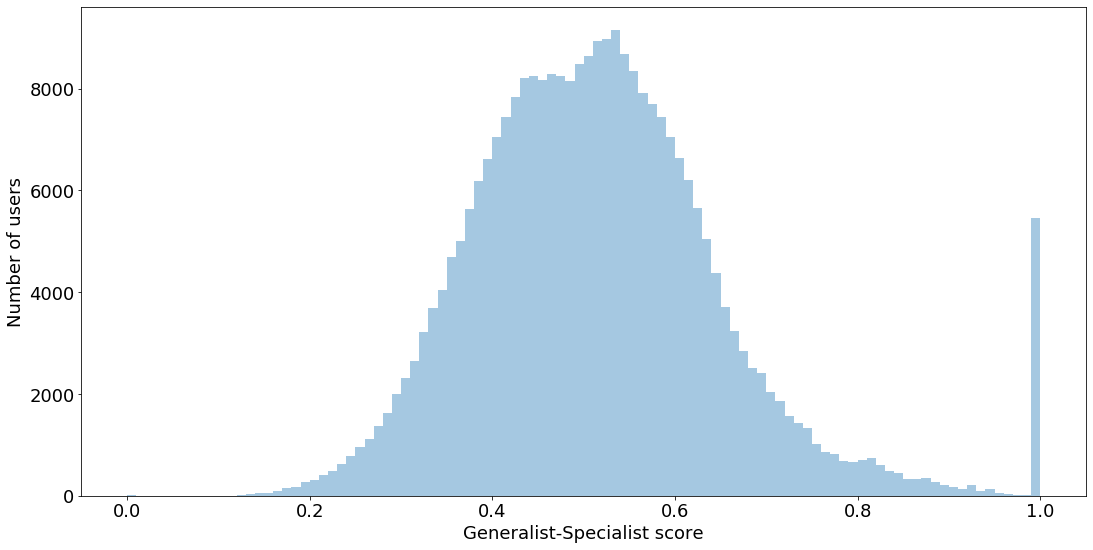

In [17]:
plt.figure(figsize=(18, 9))
sns.distplot(users_movies["gs_score"], kde=False, bins=100)
plt.xlabel("Generalist-Specialist score")
plt.ylabel("Number of users")
plt.show()

We can see that the majority of users are **generalists** since they consume a wide variety of movies. There is a spike of users with a score of 1.0, but the majority of these users only watched and rated a single movie.

In [18]:
users_movies["num_movies_rated"] = users_movies["movie_id_ratings"].apply(len)

In [21]:
specialists = users_movies[(users_movies["gs_score"] >= 0.90) & (users_movies["num_movies_rated"] > 1)]

In [22]:
logger.info(f"Number of specialists with more than 1 rating: {specialists.shape[0]}")

INFO - 16:42:10: Number of specialists with more than 1 rating: 857


## Compute Shannon Entropy

We also want to use Shannon Entropy as it is a common measure of diversity per user.

In [17]:
users_movies["shannon_entropy"] = movies_list.apply(lambda x: compute_shannon_entropy(x))

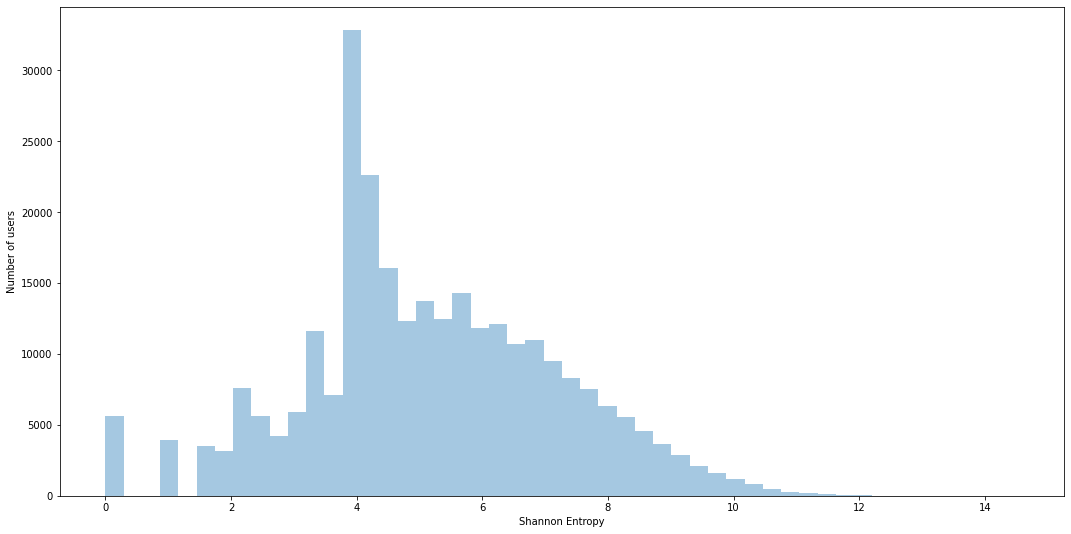

In [18]:
plt.figure(figsize=(18, 9))
sns.distplot(users_movies["shannon_entropy"], kde=False)
plt.xlabel("Shannon Entropy")
plt.ylabel("Number of users")
plt.show()